In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, accuracy_score # Explicitly import for clarity

In [2]:
try:
    bmi_df_original = pd.read_csv('./data/bodyfat.csv')
    bmi_df = bmi_df_original.copy()
    print(f"Successfully loaded data. Shape: {bmi_df.shape}")
except FileNotFoundError:
    print("ERROR: bodyfat.csv not found. Please ensure the file is in the './data/' directory.")
    # Create a dummy dataframe for the rest of the script to run without erroring out,
    # though results will not be meaningful.
    data = {'BodyFat': [20, 25, 15, 30, 22], 'Original': ['Y', 'Y', 'Y', 'Y', 'Y'],
            'Sex': ['M', 'F', 'M', 'F', 'M'], 'Age': [30, 40, 25, 50, 35],
            'Weight': [70, 60, 80, 65, 75], 'Height': [1.75, 1.60, 1.80, 1.55, 1.70],
            'Neck': [38,32,39,33,37], 'Chest': [100,90,105,92,102],
            'Abdomen': [85,75,90,80,88], 'Hip': [95,90,100,92,98],
            'Thigh': [55,50,60,52,58], 'Knee': [38,35,40,36,39],
            'Ankle': [22,20,23,21,22.5], 'Biceps': [33,30,35,31,34],
            'Forearm': [28,25,30,26,29], 'Wrist': [17,15,18,16,17.5]}
    bmi_df = pd.DataFrame(data)
    print("Created a dummy DataFrame to proceed.\n")

Successfully loaded data. Shape: (436, 16)


In [3]:
# Drop unnecessary columns
columns_to_drop = ['Original', 'Neck', 'Forearm', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Wrist']
# Ensure only existing columns are dropped
columns_to_drop_existing = [col for col in columns_to_drop if col in bmi_df.columns]
bmi_df.drop(columns=columns_to_drop_existing, inplace=True)
print(f"Columns dropped. Remaining columns: {bmi_df.columns.tolist()}")

Columns dropped. Remaining columns: ['BodyFat', 'Sex', 'Age', 'Weight', 'Height']


In [4]:
# Outlier removal using IQR
numeric_columns = ['BodyFat', 'Age', 'Weight', 'Height']
print("\n--- IQR Outlier Removal ---")
for column in numeric_columns:
    if column in bmi_df.columns:
        Q1 = bmi_df[column].quantile(0.25)
        Q3 = bmi_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        before = bmi_df.shape[0]
        bmi_df = bmi_df[(bmi_df[column] >= lower_bound) & (bmi_df[column] <= upper_bound)]
        after = bmi_df.shape[0]
        print(f"{column}: Dihapus {before - after} data outlier")
print(f"Shape after IQR outlier removal: {bmi_df.shape}")


--- IQR Outlier Removal ---
BodyFat: Dihapus 1 data outlier
Age: Dihapus 0 data outlier
Weight: Dihapus 2 data outlier
Height: Dihapus 1 data outlier
Shape after IQR outlier removal: (432, 5)


In [5]:
print("--- Physiological Plausibility Cleaning ---")
initial_rows = bmi_df.shape[0]
# BodyFat
bmi_df = bmi_df[~((bmi_df['Sex'] == 'M') & (bmi_df['BodyFat'] < 2))] # Men essential fat ~2-5%
bmi_df = bmi_df[~((bmi_df['Sex'] == 'F') & (bmi_df['BodyFat'] < 10))]# Women essential fat ~10-13%
print(f"Rows removed by BodyFat plausibility: {initial_rows - bmi_df.shape[0]}")
initial_rows = bmi_df.shape[0]
# Age (common adult range for dietary guidelines application)
bmi_df = bmi_df[(bmi_df['Age'] >= 19) & (bmi_df['Age'] <= 65)]
print(f"Rows removed by Age filtering (19-65): {initial_rows - bmi_df.shape[0]}")
print(f"Shape after plausibility cleaning: {bmi_df.shape}")
print("-----------------------------------------\n")

--- Physiological Plausibility Cleaning ---
Rows removed by BodyFat plausibility: 4
Rows removed by Age filtering (19-65): 34
Shape after plausibility cleaning: (394, 5)
-----------------------------------------



In [6]:
bmi_df['BMI'] = bmi_df['Weight'] / (bmi_df['Height'] ** 2)

In [7]:
def categorize_bmi(bmi):
    if bmi < 18.5: return 'Underweight'
    elif 18.5 <= bmi < 24.9: return 'Normal' # Simpler label
    elif 24.9 <= bmi < 29.9: return 'Overweight'
    else: return 'Obese'
bmi_df['BMI_Category'] = bmi_df['BMI'].apply(categorize_bmi)

def categorize_body_fat_gendered(row): # Based on ACE (American Council on Exercise)
    fat = row['BodyFat']
    gender = row['Sex']
    if gender == 'M':
        if fat < 6: return 'Essential_Low' # 2-5% essential
        elif fat < 14: return 'Athletes'
        elif fat < 18: return 'Fitness'
        elif fat < 25: return 'Average'
        else: return 'Obese'
    else: # Women
        if fat < 14: return 'Essential_Low' # 10-13% essential
        elif fat < 21: return 'Athletes'
        elif fat < 25: return 'Fitness'
        elif fat < 32: return 'Average'
        else: return 'Obese'
bmi_df['BodyFat_Category'] = bmi_df.apply(categorize_body_fat_gendered, axis=1)

print("--- BMI and BodyFat Categories Added ---")
print(bmi_df[['BMI_Category', 'BodyFat_Category']].value_counts())
print("----------------------------------------\n")

--- BMI and BodyFat Categories Added ---
BMI_Category  BodyFat_Category
Normal        Athletes            108
              Fitness              60
Overweight    Average              56
Normal        Average              50
Overweight    Obese                34
Normal        Essential_Low        19
Obese         Obese                15
Overweight    Fitness              15
Normal        Obese                 9
Underweight   Athletes              9
Overweight    Athletes              8
Underweight   Essential_Low         6
Obese         Average               3
Underweight   Average               1
              Fitness               1
Name: count, dtype: int64
----------------------------------------



In [8]:
def get_sedentary_calories_v2(age, sex): # Dietary Guidelines, Appendix 2, Table A2-2 (lower end for sedentary)
    sex = sex.lower()
    if 19 <= age <= 30: return 2000 if sex == 'f' else 2400
    elif 31 <= age <= 50: return 1800 if sex == 'f' else 2200 # Adjusted from 59 to 50 for common grouping
    elif 51 <= age <= 65: return 1600 if sex == 'f' else 2000 # Adjusted from 59 to 65
    else: return 1600 if sex == 'f' else 2000 # Default for >65, though filtered

def synthetic_calories_v2(row):
    sedentary_cals = get_sedentary_calories_v2(row['Age'], row['Sex'])
    bmi_cat = row['BMI_Category']
    bf_cat = row['BodyFat_Category'] # Using the ACE-like gendered categories

    target_cals = sedentary_cals

    # Activity level simulation (can be more complex, here's a simple one)
    # Assume a mix of activity levels in the dataset population
    activity_multiplier = np.random.choice([1.0, 1.2, 1.4]) # Sedentary, Lightly Active, Moderately Active
    target_cals *= activity_multiplier

    # Adjust for weight goals
    if bmi_cat == 'Underweight' or bf_cat == 'Essential_Low':
        target_cals += np.random.randint(250, 500) # Surplus for gain
    elif bmi_cat == 'Obese' or bf_cat == 'Obese':
        target_cals -= np.random.randint(300, 600) # Deficit for loss
    elif bmi_cat == 'Overweight' or bf_cat in ['Average', 'Obese']: # Catching higher end of 'Average' BF
        target_cals -= np.random.randint(150, 350) # Mild deficit

    # Ensure minimum physiological limits
    min_cal = 1200 if row['Sex'].lower() == 'f' else 1500
    target_cals = max(target_cals, min_cal)
    
    return int(round(target_cals / 50) * 50) # Round to nearest 50 for realism

In [9]:
def get_protein_rda_g_v2(age, sex): # Dietary Guidelines, Appendix 1, Table A1-2
    sex = sex.lower()
    if 19 <= age <= 65: return 46 if sex == 'f' else 56
    else: return 46 if sex == 'f' else 56 # Default for > 65 (though filtered)

def synthetic_protein_target_v2(row):
    rda = get_protein_rda_g_v2(row['Age'], row['Sex'])
    weight_kg = row['Weight']
    bmi_cat = row['BMI_Category']
    # bf_cat = row['BodyFat_Category'] # Can be used for finer tuning
    calories = row['Calories']
    sedentary_calories = get_sedentary_calories_v2(row['Age'], row['Sex'])

    # Base g/kg targets
    if bmi_cat == 'Underweight':
        g_per_kg = np.random.uniform(1.4, 1.8)
    elif bmi_cat == 'Obese':
        g_per_kg = np.random.uniform(1.2, 1.6) # Higher for satiety/muscle preservation
    elif bmi_cat == 'Overweight':
        g_per_kg = np.random.uniform(1.0, 1.5)
    else: # Normal
        if calories > sedentary_calories * 1.3: # More active
            g_per_kg = np.random.uniform(1.2, 1.6)
        elif calories > sedentary_calories * 1.1: # Lightly active
            g_per_kg = np.random.uniform(1.0, 1.3)
        else: # Sedentary
            g_per_kg = np.random.uniform(0.8, 1.1)
            
    protein_from_g_kg = g_per_kg * weight_kg
    
    # Protein should be at least RDA
    target_protein = max(rda, protein_from_g_kg)
    
    # Add some random variation
    target_protein += np.random.uniform(-7, 7)
    
    # Clip to a reasonable physiological range
    target_protein = np.clip(target_protein, 40, 220) # Adjusted max

    return round(target_protein, 1)


--- New Synthetic Calories and Protein Generated ---
          Calories    Protein
count   394.000000  394.00000
mean   2412.817259   86.57335
std     418.657654   24.92691
min    1400.000000   44.70000
25%    2050.000000   67.12500
50%    2400.000000   83.00000
75%    2750.000000  103.20000
max    3750.000000  179.10000


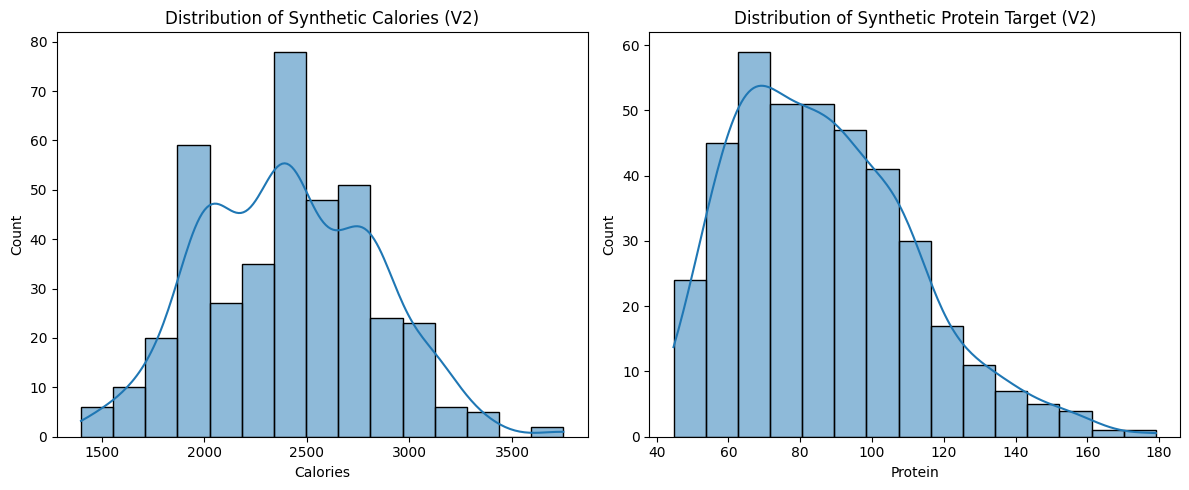

In [10]:
bmi_df['Calories'] = bmi_df.apply(synthetic_calories_v2, axis=1)
bmi_df['Protein'] = bmi_df.apply(synthetic_protein_target_v2, axis=1)

print("\n--- New Synthetic Calories and Protein Generated ---")
print(bmi_df[['Calories', 'Protein']].describe())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(bmi_df['Calories'], kde=True, bins=15)
plt.title('Distribution of Synthetic Calories (V2)')
plt.subplot(1, 2, 2)
sns.histplot(bmi_df['Protein'], kde=True, bins=15)
plt.title('Distribution of Synthetic Protein Target (V2)')
plt.tight_layout()
plt.show()

In [11]:
def bmi_mf_underweight(bmi):
    if bmi <= 18.5: return 1.0
    elif 18.5 < bmi <= 20.5: return (20.5 - bmi) / (20.5 - 18.5)
    else: return 0.0
def bmi_mf_normal(bmi):
    if 17.5 <= bmi < 18.5: return (bmi - 17.5) / (18.5 - 17.5)
    elif 18.5 <= bmi < 24.9: return 1.0
    elif 24.9 <= bmi < 26.5: return (26.5 - bmi) / (26.5 - 24.9)
    else: return 0.0
def bmi_mf_overweight(bmi):
    if 24.0 <= bmi < 24.9: return (bmi - 24.0) / (24.9 - 24.0)
    elif 24.9 <= bmi < 29.9: return 1.0
    elif 29.9 <= bmi < 31.5: return (31.5 - bmi) / (31.5 - 29.9)
    else: return 0.0
def bmi_mf_obese(bmi):
    if 29.0 <= bmi < 29.9: return (bmi - 29.0) / (29.9 - 29.0)
    elif bmi >= 29.9: return 1.0
    else: return 0.0

In [12]:
def bfm_essential_low(bf): # <6%
    if bf <= 3: return 1.0
    elif 3 < bf <= 7: return (7 - bf) / (7 - 3)
    else: return 0.0
def bfm_athletes(bf): # 6-13%
    if 5 < bf <= 9: return (bf - 5) / (9 - 5)
    elif 9 < bf <= 13: return 1.0
    elif 13 < bf <= 15: return (15 - bf) / (15 - 13)
    else: return 0.0
def bfm_fitness(bf): # 14-17%
    if 13 <= bf < 15: return (bf - 13) / (15 - 13)
    elif 15 <= bf < 18: return 1.0
    elif 18 <= bf < 20: return (20 - bf) / (20 - 18)
    else: return 0.0
def bfm_average(bf): # 18-24%
    if 18 <= bf < 21: return (bf - 18) / (21 - 18)
    elif 21 <= bf < 25: return 1.0
    elif 25 <= bf < 27: return (27 - bf) / (27 - 25)
    else: return 0.0
def bfm_obese(bf): # >25%
    if bf < 24: return 0.0
    elif 24 <= bf < 27: return (bf - 24) / (27 - 24)
    else: return 1.0

In [13]:
def bfw_essential_low(bf): # <14%
    if bf <= 11: return 1.0
    elif 11 < bf <= 15: return (15 - bf) / (15 - 11)
    else: return 0.0
def bfw_athletes(bf): # 14-20%
    if 13 < bf <= 17: return (bf - 13) / (17 - 13)
    elif 17 < bf <= 20: return 1.0
    elif 20 < bf <= 22: return (22 - bf) / (22 - 20)
    else: return 0.0
def bfw_fitness(bf): # 21-24%
    if 20 <= bf < 22: return (bf - 20) / (22 - 20)
    elif 22 <= bf < 25: return 1.0
    elif 25 <= bf < 27: return (27 - bf) / (27 - 25)
    else: return 0.0
def bfw_average(bf): # 25-31%
    if 25 <= bf < 28: return (bf - 25) / (28 - 25)
    elif 28 <= bf < 32: return 1.0
    elif 32 <= bf < 34: return (34 - bf) / (34 - 32)
    else: return 0.0
def bfw_obese(bf): # >32%
    if bf < 31: return 0.0
    elif 31 <= bf < 34: return (bf - 31) / (34 - 31)
    else: return 1.0

In [14]:
protein_bins_edges_V2 = [0, 55, 80, 120, 160, float('inf')] # Example: Adjusted
# Labels: Very Low (<55), Low (55-80), Medium (80-120), High (120-160), Very High (>160)
print(f"Protein Bins for F1/Accuracy: {protein_bins_edges_V2}")

Protein Bins for F1/Accuracy: [0, 55, 80, 120, 160, inf]


In [15]:
def p_very_low_mf(p): # Centered around ~40-45, for bin <55
    if p <= 40: return 1.0
    elif 40 < p <= 55: return (55-p)/(55-40)
    else: return 0.0
def p_low_mf(p):      # Centered around ~67.5, for bin 55-80
    if 45 < p <= 67.5: return (p-45)/(67.5-45)
    elif 67.5 < p <= 85: return (85-p)/(85-67.5) # Slightly wider fall for overlap
    else: return 0.0
def p_medium_mf(p):   # Centered around ~100, for bin 80-120
    if 75 < p <= 100: return (p-75)/(100-75)
    elif 100 < p <= 125: return (125-p)/(125-100)
    else: return 0.0
def p_high_mf(p):     # Centered around ~140, for bin 120-160
    if 115 < p <= 140: return (p-115)/(140-115)
    elif 140 < p <= 165: return (165-p)/(165-140)
    else: return 0.0
def p_very_high_mf(p):# For bin >160
    if p < 155: return 0.0
    elif 155 <= p < 175: return (p-155)/(175-155)
    else: return 1.0

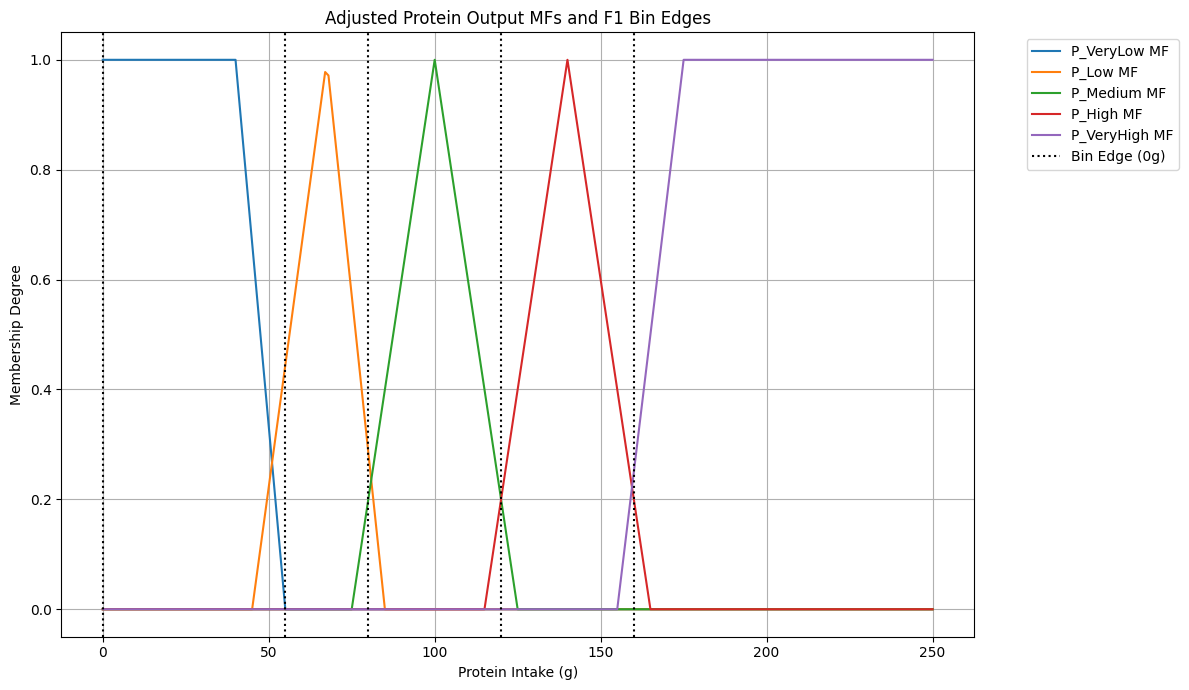


--- Output Protein MFs Defined and Aligned with Bins ---


In [16]:
x_protein_plot = np.arange(0, 251, 1)
plt.figure(figsize=(12, 7))
plt.plot(x_protein_plot, [p_very_low_mf(x) for x in x_protein_plot], label='P_VeryLow MF')
plt.plot(x_protein_plot, [p_low_mf(x) for x in x_protein_plot], label='P_Low MF')
plt.plot(x_protein_plot, [p_medium_mf(x) for x in x_protein_plot], label='P_Medium MF')
plt.plot(x_protein_plot, [p_high_mf(x) for x in x_protein_plot], label='P_High MF')
plt.plot(x_protein_plot, [p_very_high_mf(x) for x in x_protein_plot], label='P_VeryHigh MF')
for edge in protein_bins_edges_V2:
    plt.axvline(edge, color='k', linestyle=':', linewidth=1.5, label=f'Bin Edge ({edge}g)' if edge == protein_bins_edges_V2[0] else None)
plt.title('Adjusted Protein Output MFs and F1 Bin Edges')
plt.xlabel('Protein Intake (g)')
plt.ylabel('Membership Degree'); plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left'); plt.grid(True); plt.tight_layout(); plt.show()

print("\n--- Output Protein MFs Defined and Aligned with Bins ---")

In [17]:
bmi_terms = {'Underweight': bmi_mf_underweight, 'Normal': bmi_mf_normal, 'Overweight': bmi_mf_overweight, 'Obese': bmi_mf_obese}
bfm_terms = {'Essential_Low': bfm_essential_low, 'Athletes': bfm_athletes, 'Fitness': bfm_fitness, 'Average': bfm_average, 'Obese': bfm_obese}
bfw_terms = {'Essential_Low': bfw_essential_low, 'Athletes': bfw_athletes, 'Fitness': bfw_fitness, 'Average': bfw_average, 'Obese': bfw_obese}
protein_terms_map = {'Very_Low': p_very_low_mf, 'Low': p_low_mf, 'Medium': p_medium_mf, 'High': p_high_mf, 'Very_High': p_very_high_mf}

In [18]:
rules = [
    # BMI_Category, BodyFat_Category -> Protein_Recommendation_Category
    (('Underweight', 'Essential_Low'), 'Very_High'), (('Underweight', 'Athletes'),  'Very_High'),
    (('Underweight', 'Fitness'),   'High'),      (('Underweight', 'Average'), 'Medium'),
    (('Underweight', 'Obese'),     'Medium'),

    (('Normal', 'Essential_Low'), 'High'),      (('Normal', 'Athletes'),  'High'),
    (('Normal', 'Fitness'),   'Medium'),    (('Normal', 'Average'), 'Medium'),
    (('Normal', 'Obese'),     'Low'),

    (('Overweight', 'Essential_Low'), 'High'),   (('Overweight', 'Athletes'),  'Medium'),
    (('Overweight', 'Fitness'),   'Medium'), (('Overweight', 'Average'), 'Low'),
    (('Overweight', 'Obese'),     'Low'),

    (('Obese', 'Essential_Low'), 'Medium'),    (('Obese', 'Athletes'),  'Medium'),
    (('Obese', 'Fitness'),   'Low'),       (('Obese', 'Average'), 'Low'),
    (('Obese', 'Obese'),     'Very_Low')
]
print(f"\n--- {len(rules)} Fuzzy Rules Defined ---")


--- 20 Fuzzy Rules Defined ---


In [19]:
def fuzzify_inputs(bmi_val, bodyfat_val, gender_val):
    f_bmi = {term: func(bmi_val) for term, func in bmi_terms.items()}
    bf_select_terms = bfm_terms if gender_val == 'M' else bfw_terms
    f_bf = {term: func(bodyfat_val) for term, func in bf_select_terms.items()}
    return f_bmi, f_bf

def apply_rules_mamdani(f_bmi, f_bf):
    # Aggregated output fuzzy set (strengths for each output linguistic term)
    output_activation_strengths = {term: 0.0 for term in protein_terms_map.keys()}
    active_rules_details = []

    for (bmi_condition, bf_condition), protein_consequence in rules:
        bmi_strength = f_bmi.get(bmi_condition, 0)
        bf_strength = f_bf.get(bf_condition, 0)
        
        # AND operator for rule antecedent
        rule_strength = min(bmi_strength, bf_strength)
        
        if rule_strength > 0:
            active_rules_details.append({
                "BMI_Term": bmi_condition, "BMI_Strength": round(bmi_strength,2),
                "BF_Term": bf_condition, "BF_Strength": round(bf_strength,2),
                "Rule_Strength": round(rule_strength,2), "Consequence": protein_consequence
            })
            # Aggregate rule outputs (MAX for ORing rules leading to same consequence)
            output_activation_strengths[protein_consequence] = max(output_activation_strengths[protein_consequence], rule_strength)
            
    return output_activation_strengths, active_rules_details

In [20]:
protein_domain_samples = np.arange(0, 251, 1) # Finer samples for centroid

def defuzzify_mamdani(aggregated_strengths):
    numerator = 0
    denominator = 0
    
    # Create the aggregated fuzzy output shape
    aggregated_output_curve = np.zeros_like(protein_domain_samples, dtype=float)
    for z_idx, z_val in enumerate(protein_domain_samples):
        max_membership_at_z = 0
        for protein_term, strength in aggregated_strengths.items():
            if strength > 0: # Only consider if the rule fired for this term
                term_mf_value = protein_terms_map[protein_term](z_val)
                max_membership_at_z = max(max_membership_at_z, min(term_mf_value, strength)) # Clipping
        aggregated_output_curve[z_idx] = max_membership_at_z

    if np.sum(aggregated_output_curve) == 0: # No rules fired significantly
        return 0 # Or a default median value, e.g., 80
        
    numerator = np.sum(protein_domain_samples * aggregated_output_curve)
    denominator = np.sum(aggregated_output_curve)
    
    return numerator / denominator if denominator != 0 else 0

In [21]:
constants_protein_V2 = {
    'Very_Low': 45,  # Representative of <55 bin
    'Low': 67.5,   # Midpoint of 55-80 bin
    'Medium': 100,   # Midpoint of 80-120 bin
    'High': 140,    # Midpoint of 120-160 bin
    'Very_High': 175 # Representative of >160 bin
}
print(f"\nSugeno Constants: {constants_protein_V2}")


Sugeno Constants: {'Very_Low': 45, 'Low': 67.5, 'Medium': 100, 'High': 140, 'Very_High': 175}


In [22]:
def defuzzify_sugeno(rule_strengths_per_consequence): # Takes aggregated strengths
    numerator = 0
    denominator = 0
    for protein_term, strength in rule_strengths_per_consequence.items():
        numerator += strength * constants_protein_V2[protein_term]
        denominator += strength
    return numerator / denominator if denominator != 0 else 0


--- Starting Evaluation on 394 samples ---

--- Performance Metrics (V2) ---
F1 Score (Mamdani - V2): 0.1007
Accuracy (Mamdani - Binned V2): 21.32%
F1 Score (Sugeno - V2): 0.0965
Accuracy (Sugeno - Binned V2): 20.05%

--- Sample Predictions (V2) ---
         BMI  BodyFat Sex  Calories  Protein  Protein_Mamdani_Pred_V2  \
0  23.651298     12.3   M      3350    102.9               140.000000   
1  23.213020      6.1   M      2900    100.7               140.000000   
2  24.748441     25.3   M      2850     77.2                84.974599   
3  24.751890     10.4   M      2400     93.4               120.281917   
4  25.512042     28.7   M      2350    128.5                65.832274   

   Protein_Sugeno_Pred_V2 BMI_Category BodyFat_Category  
0              140.000000       Normal         Athletes  
1              140.000000       Normal         Athletes  
2               83.927796       Normal            Obese  
3              121.793214       Normal         Athletes  
4               67.5

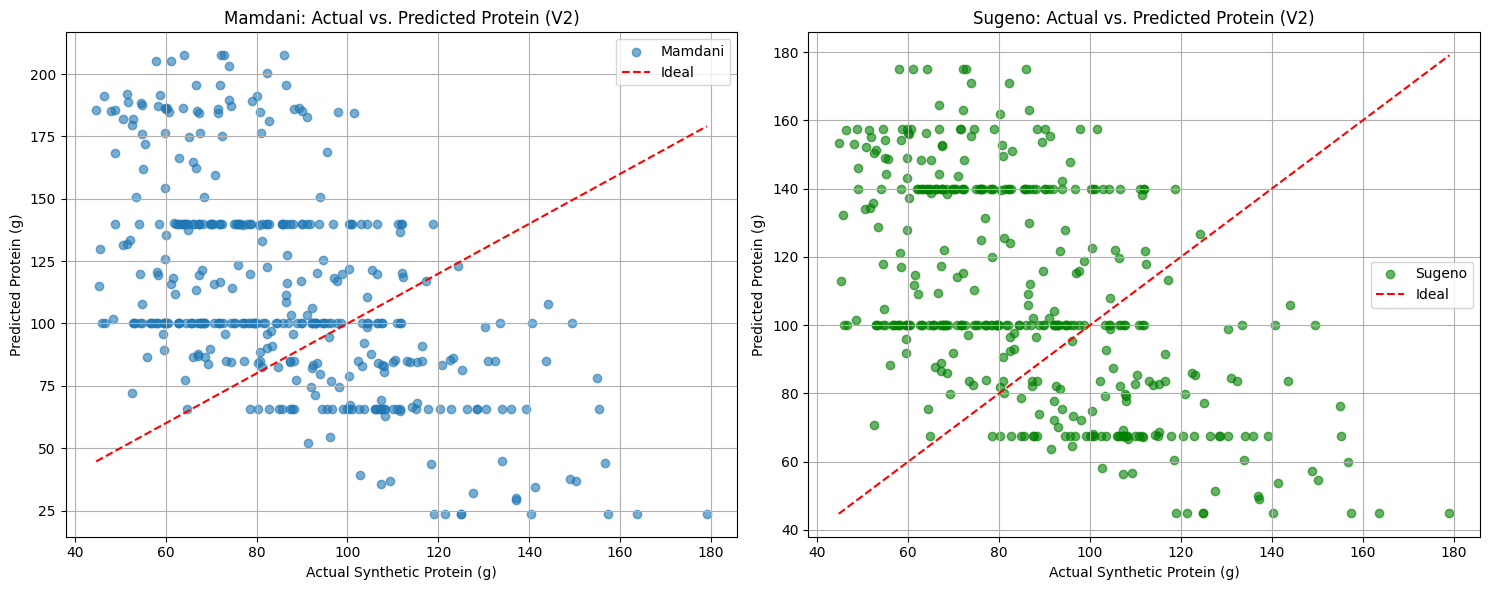


--- Program End ---


In [23]:
mamdani_predictions = []
sugeno_predictions = []

if bmi_df.empty:
    print("\nDataFrame is empty after cleaning. Cannot perform evaluation.")
else:
    print(f"\n--- Starting Evaluation on {bmi_df.shape[0]} samples ---")
    for idx, row in bmi_df.iterrows():
        bmi_val = row['BMI']
        bodyfat_val = row['BodyFat']
        gender_val = row['Sex']

        f_bmi, f_bf = fuzzify_inputs(bmi_val, bodyfat_val, gender_val)
        aggregated_strengths, _ = apply_rules_mamdani(f_bmi, f_bf) # Mamdani aggregation
        
        mam_pred = defuzzify_mamdani(aggregated_strengths)
        mamdani_predictions.append(mam_pred)
        
        sug_pred = defuzzify_sugeno(aggregated_strengths) # Use same aggregated strengths
        sugeno_predictions.append(sug_pred)

    bmi_df['Protein_Mamdani_Pred_V2'] = mamdani_predictions
    bmi_df['Protein_Sugeno_Pred_V2'] = sugeno_predictions

    # Binning for F1 and Accuracy
    protein_actual_binned_V2 = pd.cut(bmi_df['Protein'], bins=protein_bins_edges_V2, labels=False, include_lowest=True, duplicates='drop')
    mamdani_pred_binned_V2 = pd.cut(bmi_df['Protein_Mamdani_Pred_V2'], bins=protein_bins_edges_V2, labels=False, include_lowest=True, duplicates='drop')
    sugeno_pred_binned_V2 = pd.cut(bmi_df['Protein_Sugeno_Pred_V2'], bins=protein_bins_edges_V2, labels=False, include_lowest=True, duplicates='drop')

    # Filter out NaNs from binning if any value falls outside all bins
    valid_actual = protein_actual_binned_V2.dropna()
    
    valid_mamdani_pred = mamdani_pred_binned_V2.loc[valid_actual.index].dropna()
    actual_for_mamdani = valid_actual.loc[valid_mamdani_pred.index]
    
    valid_sugeno_pred = sugeno_pred_binned_V2.loc[valid_actual.index].dropna()
    actual_for_sugeno = valid_actual.loc[valid_sugeno_pred.index]


    print("\n--- Performance Metrics (V2) ---")
    if not actual_for_mamdani.empty and not valid_mamdani_pred.empty:
        f1_mamdani_V2 = f1_score(actual_for_mamdani, valid_mamdani_pred, average='macro', zero_division=0)
        acc_mamdani_V2 = accuracy_score(actual_for_mamdani, valid_mamdani_pred)
        print(f"F1 Score (Mamdani - V2): {f1_mamdani_V2:.4f}")
        print(f"Accuracy (Mamdani - Binned V2): {acc_mamdani_V2 * 100:.2f}%")
    else:
        print("Could not calculate Mamdani F1/Accuracy: Not enough valid binned predictions.")

    if not actual_for_sugeno.empty and not valid_sugeno_pred.empty:
        f1_sugeno_V2 = f1_score(actual_for_sugeno, valid_sugeno_pred, average='macro', zero_division=0)
        acc_sugeno_V2 = accuracy_score(actual_for_sugeno, valid_sugeno_pred)
        print(f"F1 Score (Sugeno - V2): {f1_sugeno_V2:.4f}")
        print(f"Accuracy (Sugeno - Binned V2): {acc_sugeno_V2 * 100:.2f}%")
    else:
        print("Could not calculate Sugeno F1/Accuracy: Not enough valid binned predictions.")

    print("\n--- Sample Predictions (V2) ---")
    print(bmi_df[['BMI', 'BodyFat', 'Sex', 'Calories', 'Protein', 'Protein_Mamdani_Pred_V2', 'Protein_Sugeno_Pred_V2', 'BMI_Category', 'BodyFat_Category']].head())

    # Scatter plot for visual inspection
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(bmi_df['Protein'], bmi_df['Protein_Mamdani_Pred_V2'], alpha=0.6, label='Mamdani')
    plt.plot([bmi_df['Protein'].min(), bmi_df['Protein'].max()], [bmi_df['Protein'].min(), bmi_df['Protein'].max()], 'r--', label='Ideal')
    plt.title('Mamdani: Actual vs. Predicted Protein (V2)')
    plt.xlabel('Actual Synthetic Protein (g)'); plt.ylabel('Predicted Protein (g)'); plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.scatter(bmi_df['Protein'], bmi_df['Protein_Sugeno_Pred_V2'], alpha=0.6, color='green', label='Sugeno')
    plt.plot([bmi_df['Protein'].min(), bmi_df['Protein'].max()], [bmi_df['Protein'].min(), bmi_df['Protein'].max()], 'r--', label='Ideal')
    plt.title('Sugeno: Actual vs. Predicted Protein (V2)')
    plt.xlabel('Actual Synthetic Protein (g)'); plt.ylabel('Predicted Protein (g)'); plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n--- Program End ---")

In [24]:
from sklearn.metrics import r2_score
if not bmi_df.empty:
    r2_mamdani = r2_score(bmi_df['Protein'], bmi_df['Protein_Mamdani_Pred_V2'])
    r2_sugeno = r2_score(bmi_df['Protein'], bmi_df['Protein_Sugeno_Pred_V2'])
    print(f"\nR-squared (Mamdani): {r2_mamdani:.4f}")
    print(f"R-squared (Sugeno): {r2_sugeno:.4f}")


R-squared (Mamdani): -5.7148
R-squared (Sugeno): -3.8948


In [25]:
from sklearn.metrics import precision_score, recall_score

# Assuming valid_actual, valid_mamdani_pred, valid_sugeno_pred are defined
# from your previous F1/accuracy calculations (binned and NaNs handled)

if not actual_for_mamdani.empty and not valid_mamdani_pred.empty:
    f1_mamdani_weighted = f1_score(actual_for_mamdani, valid_mamdani_pred, average='weighted', zero_division=0)
    precision_mamdani_weighted = precision_score(actual_for_mamdani, valid_mamdani_pred, average='weighted', zero_division=0)
    recall_mamdani_weighted = recall_score(actual_for_mamdani, valid_mamdani_pred, average='weighted', zero_division=0)
    print(f"\nWeighted F1 (Mamdani): {f1_mamdani_weighted:.4f}")
    print(f"Weighted Precision (Mamdani): {precision_mamdani_weighted:.4f}")
    print(f"Weighted Recall (Mamdani): {recall_mamdani_weighted:.4f}")

if not actual_for_sugeno.empty and not valid_sugeno_pred.empty:
    f1_sugeno_weighted = f1_score(actual_for_sugeno, valid_sugeno_pred, average='weighted', zero_division=0)
    precision_sugeno_weighted = precision_score(actual_for_sugeno, valid_sugeno_pred, average='weighted', zero_division=0)
    recall_sugeno_weighted = recall_score(actual_for_sugeno, valid_sugeno_pred, average='weighted', zero_division=0)
    print(f"\nWeighted F1 (Sugeno): {f1_sugeno_weighted:.4f}")
    print(f"Weighted Precision (Sugeno): {precision_sugeno_weighted:.4f}")
    print(f"Weighted Recall (Sugeno): {recall_sugeno_weighted:.4f}")


Weighted F1 (Mamdani): 0.2212
Weighted Precision (Mamdani): 0.2352
Weighted Recall (Mamdani): 0.2132

Weighted F1 (Sugeno): 0.2127
Weighted Precision (Sugeno): 0.2300
Weighted Recall (Sugeno): 0.2005


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

if not bmi_df.empty:
    print("\n--- Regression Metrics (Comparing Crisp Numerical Outputs) ---")
    mae_mamdani = mean_absolute_error(bmi_df['Protein'], bmi_df['Protein_Mamdani_Pred_V2'])
    mse_mamdani = mean_squared_error(bmi_df['Protein'], bmi_df['Protein_Mamdani_Pred_V2'])
    rmse_mamdani = np.sqrt(mse_mamdani)
    print(f"Mamdani - MAE: {mae_mamdani:.2f}g, MSE: {mse_mamdani:.2f}g^2, RMSE: {rmse_mamdani:.2f}g")

    mae_sugeno = mean_absolute_error(bmi_df['Protein'], bmi_df['Protein_Sugeno_Pred_V2'])
    mse_sugeno = mean_squared_error(bmi_df['Protein'], bmi_df['Protein_Sugeno_Pred_V2'])
    rmse_sugeno = np.sqrt(mse_sugeno)
    print(f"Sugeno  - MAE: {mae_sugeno:.2f}g, MSE: {mse_sugeno:.2f}g^2, RMSE: {rmse_sugeno:.2f}g")

    # Accuracy within Tolerance (re-iterating from your code for completeness)
    absolute_tolerance_grams = 20 # Example: +/- 20g (wider than before)
    mamdani_within_tolerance = abs(bmi_df['Protein'] - bmi_df['Protein_Mamdani_Pred_V2']) <= absolute_tolerance_grams
    acc_mamdani_tol = mamdani_within_tolerance.mean()
    sugeno_within_tolerance = abs(bmi_df['Protein'] - bmi_df['Protein_Sugeno_Pred_V2']) <= absolute_tolerance_grams
    acc_sugeno_tol = sugeno_within_tolerance.mean()
    print(f"Mamdani - Accuracy within +/- {absolute_tolerance_grams}g: {acc_mamdani_tol * 100:.2f}%")
    print(f"Sugeno  - Accuracy within +/- {absolute_tolerance_grams}g: {acc_sugeno_tol * 100:.2f}%")


--- Regression Metrics (Comparing Crisp Numerical Outputs) ---
Mamdani - MAE: 52.06g, MSE: 4161.68g^2, RMSE: 64.51g
Sugeno  - MAE: 46.46g, MSE: 3033.65g^2, RMSE: 55.08g
Mamdani - Accuracy within +/- 20g: 21.32%
Sugeno  - Accuracy within +/- 20g: 21.83%
